In [20]:
# import the libraries for the visualization
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import random

# import the libraries to perform the regression model
from scipy.stats import chi2_contingency
from sklearn import linear_model
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks
from imblearn.pipeline import make_pipeline
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import warnings
from sklearn.exceptions import ConvergenceWarning
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

warnings.filterwarnings("ignore", category=ConvergenceWarning)

In [21]:
# load the dataset
dataset = pd.read_csv('data/sport_sessionformat.csv')
activity_dataset = pd.read_csv('data/step_sport_activity.csv')

In [22]:
dataset.head()

,Unnamed: 0,type of activity,location,company,degree,department,neighborhood,sex
0,0,Walking,outdoor,company,MSc,Engineering and Applied Sciences,Trento South (Bolghera/Clarina/San Bartolomeo/...,Female
1,1,Walking,outdoor,company,MSc,Engineering and Applied Sciences,Trento South (Bolghera/Clarina/San Bartolomeo/...,Female
2,2,Walking,outdoor,company,MSc,Engineering and Applied Sciences,Trento South (Bolghera/Clarina/San Bartolomeo/...,Female
3,3,Walking,outdoor,company,MSc,Engineering and Applied Sciences,Trento South (Bolghera/Clarina/San Bartolomeo/...,Female
4,4,Walking,outdoor,company,MSc,Engineering and Applied Sciences,Trento South (Bolghera/Clarina/San Bartolomeo/...,Female


In [23]:
# remove unecessary columns
dataset = dataset.drop(['Unnamed: 0'], axis=1)
dataset.head()

,type of activity,location,company,degree,department,neighborhood,sex
0,Walking,outdoor,company,MSc,Engineering and Applied Sciences,Trento South (Bolghera/Clarina/San Bartolomeo/...,Female
1,Walking,outdoor,company,MSc,Engineering and Applied Sciences,Trento South (Bolghera/Clarina/San Bartolomeo/...,Female
2,Walking,outdoor,company,MSc,Engineering and Applied Sciences,Trento South (Bolghera/Clarina/San Bartolomeo/...,Female
3,Walking,outdoor,company,MSc,Engineering and Applied Sciences,Trento South (Bolghera/Clarina/San Bartolomeo/...,Female
4,Walking,outdoor,company,MSc,Engineering and Applied Sciences,Trento South (Bolghera/Clarina/San Bartolomeo/...,Female


# Pre-processing & data cleaning
all the nan values have already been dropped in the data cleaning process of the previous steps (except for the neighborhood variable, which will be considered in the following sections)

In [24]:
dataset.shape

(844, 7)

# Explanatory Data Analysis on the dataset

## Univariate analysis
From displaying the distribution of the variable we notice that many have unbalanced classes, which is not that good unfortunately.

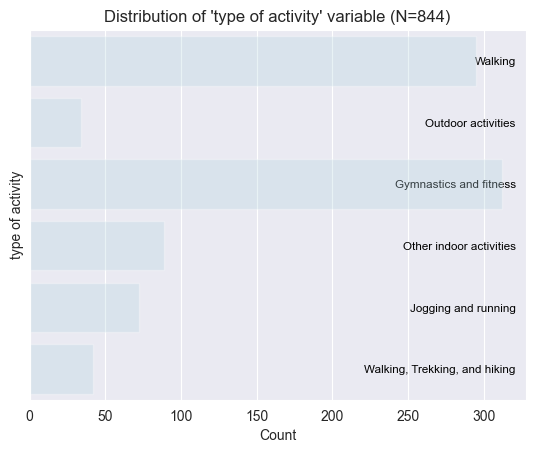

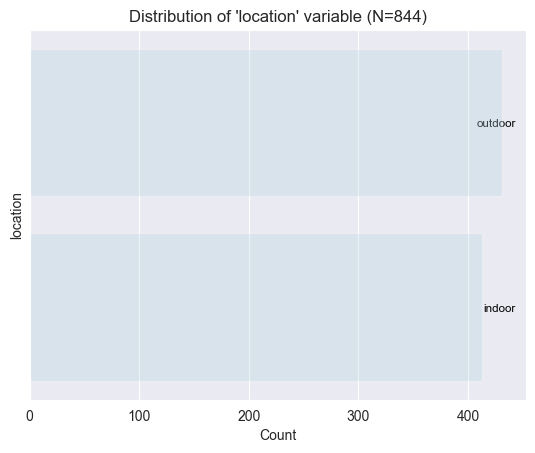

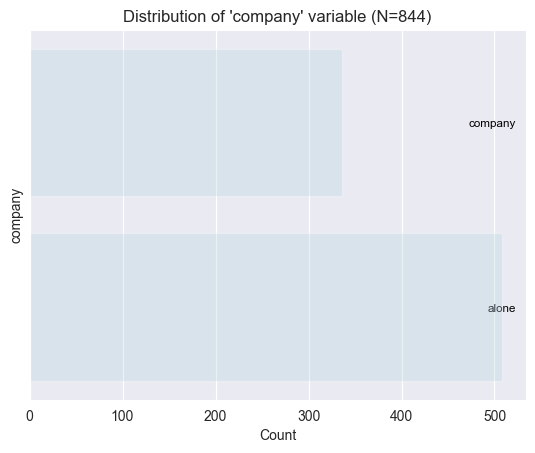

In [25]:
# observe sport related variables
variables = ['type of activity', 'location', 'company']

for var in variables:
    sns.countplot(y=var, data=dataset, orient="h", color='lightblue', alpha=0.3)
    plt.title(f"Distribution of '{var}' variable (N={dataset[var].shape[0]})")
    plt.xlabel('Count')
    plt.ylabel(var)
    plt.yticks( fontsize='small', x=1.0, color='black')
    plt.tight_layout
    plt.show()

# MODEL IMPLEMENTATION
To simplify the analyses we'll define a set of function that will be recursively used for each analysis we want to implement.
Ath the end of the script everything is wrapped up in a single function.

## functions related to the analysis of balanced/unbalanced variables
We balance the dataset using a mixed technique. Indeed we implement:
- SMOTE (Synthetic Minority Oversampling Technique) to oversample the minority classes. SMOTE technique works by randomly selecting an example, namely a, from the minority class and then k of its nearest neighbors are chosen. Then the algorithm draws a line from one of these new instances and, namely b, and the instance a and it generates the new synthetic instances from a convex combination of a and b.
- Tomek Links to undersample the majority class. It is a modified Condensed Nearest Neighbors, where each pair of observations a and b is selected considering three rules:
    - the observation’s a nearest neighbor is b.
    - the observation’s b nearest neighbor is a.
    - a and b belong to different classes
	Through this definition of pair it is possible to find a sample of data from the majority class having the lowest Euclidean distance with the minority class and then remove it.


In [26]:
def get_balanced_variables(data, threshold=0.3):
    """
    Function to identify variables with balanced classes (within a certain threshold).

    Args:
    - data: DataFrame containing all variables
    - threshold: threshold to determine class balance

    Returns:
    - List of variable names with approximately balanced classes
    """
    balanced_vars = []

    for col in data.columns:

        value_counts = data[col].value_counts(normalize=True)
        min_class_prop = value_counts.min()

        if min_class_prop >= threshold and min_class_prop <= (1 - threshold):
            balanced_vars.append(col)

    return balanced_vars

# -------------------------------------------------------------------------------------

def balance_dataset(X, y):
    """
    Function to create a balanced dataset using a combined oversampling and undersampling technique.

    Args:
    - X: set of predictors
    - y: target variable

    Returns:
    - X_resampled: balanced set of predictors
    - y_resampled: balanced target variable
    """

    # define the combination of SMOTE and TomekLinks techniques
    combined_sampler = make_pipeline(SMOTE(random_state=42), TomekLinks())

    # apply the combined_sampler function
    X_resampled, y_resampled = combined_sampler.fit_resample(X, y)

    return X_resampled, y_resampled



## functions related to the splitting process of training and test set

In [27]:
def split_dataset(predictors, y):
    '''
    Function to manually split the dataset into training and test sets

    Args:
    - predictors: DataFrame containing predictors
    - y: target variable

    Returns:
    - X_train, X_test, y_train, y_test with the assurance they don't overlap
    '''
    # create a single dataframe
    data = pd.concat([predictors, y], axis=1)

    # shuffle indices with random_state set to ensure reproducibility
    random_state = 42  # random state
    indices = np.random.RandomState(random_state).permutation(data.index)

    # calculate the split point
    split = int(len(indices) * 0.8)  # we decide to use 80-20 split

    # split the indices
    train_indices = indices[:split]
    test_indices = indices[split:]

    # create the training and test sets
    X_train = predictors.loc[train_indices]
    X_test = predictors.loc[test_indices]
    y_train = y.loc[train_indices]
    y_test = y.loc[test_indices]

    # check for overlapping samples in the split
    train_samples_manual = set(train_indices)
    test_samples_manual = set(test_indices)

    overlapping_samples_manual = train_samples_manual.intersection(test_samples_manual)

    if overlapping_samples_manual:
        print("Error! There are some overlapping samples")

    else:
        #print("No overlapping samples found between the manually split training and test sets.")
        return X_train, X_test, y_train, y_test


## functions related to the implementation of logistic regression model
The hyper-parameters of the model are:
- C: is the inverse of the regularization strength. It indicates whether the model should “trust” the training data or not.
- penalty: is a regularization technique to avoid over-fitting. The penalty is applied over the coefficient of the features.
- solver: is the algorithm used in the optimization problem.
- class weight: is the weight associated with the classes.
- maximum number of iteration: it is the maximum number of iterations used for the solver to converge.


In [28]:
# building the model
def compute_model(X_train, y_train, X_test, y_test):
    '''
    Function to compute the logistic regression model
    We use a GridSearch to find the best parameters for each model to avoid overfitting

    Args:
    - X_train: training test ot the predictors
    - y_train: training test ot the target variable
    - X: DataFrame containing predictors
    - y: Pd.Series of the variable to predict

    Returns:
    - best_params: the parameters of the model with the best results
    - evaluation_metrics: a dict of the evaluation metrics for the model with the best results
    '''

    # compute the model
    model = linear_model.LogisticRegression()

    # hyperparameters grid for tuning
    param_grid = {
        'C': [0.1, 1.0, 10.0],
        'penalty': ['l1', 'l2'],
        'solver': ['liblinear', 'saga'],
        'class_weight': [None, 'balanced'],
        'max_iter': [100, 200, 300, 500, 700, 1000]}

    # we perform the GridSearchCV for hyperparameter tuning
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy')
    grid_search.fit(X_train, y_train)

    # define the best hyperparameters
    best_params = grid_search.best_params_
    best_model = grid_search.best_estimator_

    # predict on the test set using the best model
    y_pred = best_model.predict(X_test)

    # compute the most common classification evaluation metrics
    evaluation_metrics = {}

    evaluation_metrics['accuracy'] = accuracy_score(y_test, y_pred)
    evaluation_metrics['precision'] = precision_score(y_test, y_pred, average='weighted')
    evaluation_metrics['recall'] = recall_score(y_test, y_pred, average='weighted')
    evaluation_metrics['F1-score'] = f1_score(y_test, y_pred, average='weighted')
    evaluation_metrics['ROC AUC'] = roc_auc_score(y_test, y_pred)  # Only for binary classification

    return best_params, evaluation_metrics

## functions related to feature selection process
we use bivariate analysis to identify the most relevant predictors in the analysis and improve the regression model

In [29]:
def cr_calculate(preds, y):
    '''
    Function to compute the Cramer's V test between the predictors and the target variable

    Args:
    - preds: DataFrame of the predictors
    - y: Pd.Series of the variable to predict

    Returns:
    - res: dictionary with relative Cramer's V value and p-value for each association
    '''
    var_preds = list(preds.columns)
    res = []

    for var in var_preds:
        current_res ={}
        current_res['x var'] = var
        current_res['y var'] = y.name

        # compute the contingency table and the chi2 test
        current_data = np.array(pd.crosstab(preds[var], y))
        chitest = chi2_contingency(current_data)

        # compute the Cramer's V test
        n = np.sum(current_data)
        minDim = min(current_data.shape)-1
        v_value = np.sqrt((chitest[0]/n) / minDim)

        current_res['v-value'] = v_value
        current_res['p-value'] = chitest[1]

        if chitest[1] <= 0.01:
            current_res['p-value sig'] = "***"

        elif chitest[1] > 0.01 and chitest[1] <= 0.05:
            current_res['p-value sig'] = "**"

        elif chitest[1] > 0.05 and chitest[1] <= 0.1:
            current_res['p-value sig'] = "*"

        elif chitest[1] > 0.1:
            current_res['p-value sig'] = "no significant"

        res.append(current_res)

    return res

# -------------------------------------------------------------------------

def preds_selection(bivariate_vals, threshold, significance):
    '''
    Function to parse all the bivariate analyses and select the most important predictors

    Args:
    - bivariate_vals: list of dictionaries explaining the relation between each predictor and the target variable
    - threshold: float value for the feature selection
    Returns:
    - new_predictors: list of the most important predictors
    '''
    new_predictors = []

    # we select the most important predictors for the y variable
    for el in bivariate_vals:
        # drop the not significant or not very significant cases
        if el['p-value sig'] == significance:
            # drop the cases with a weak relation
            if el['v-value'] >= threshold:
                new_predictors.append(el['x var'])

    return new_predictors

# ------------------------------------------------------------------
def feature_sel(bivariate_vals, threshold, significance):
    '''
    Function to find the predictors satisfying a specific threshold and significance level in the bivariate analysis

    Args:
    - bivariate_vals: list of dictionaries explaining the relation between each predictor and the target variable
    - threshold: float value for the feature selection
    - significance: level of stastically significance of the bivariate analysis

    Returns:
    - new_predictors: list of predictors satisfying a specific threshold and significance level
    - threshold: float number
    - significance: level of significance of the threshold
    '''
    new_predictors = preds_selection(bivariate_vals, threshold, significance)

    while significance != '' and len(new_predictors) == 0:
        #print(f"no predictors found with threshold {threshold} and significance {significance}")

        if threshold > 0.1:
            threshold = round(threshold - 0.1, 1)
        else:
            threshold = 1.0
            if significance == '***':
                significance = '**'
            elif significance == '**':
                significance = '*'

        new_predictors = preds_selection(bivariate_vals, threshold, significance)

    return threshold, new_predictors, significance

## function to compute everything together

In [30]:
def compute_all(predictors, target):
    '''
    Function to perform a logistic regression model on the target variable, evaluate it and then improve it.

    Args:
    - predictors: DataFrame of the predictors
    - target: pd.Series of the target variable

    Returns:
    - model_implementation: a dict with all the information considering the model computed
    '''

    model_features = {}
    model_features['target'] = target.name

    # we balance the dataset to have target variable with balanced classes
    balance_X, balance_y = balance_dataset(predictors, target)

    # find the variables among the predictors with balanced classes
    selected_predictors = get_balanced_variables(balance_X)

    X_train, X_test, y_train, y_test = split_dataset(balance_X[selected_predictors], balance_y)

    initial_params, initial_eval_metrics = compute_model(X_train, y_train, X_test, y_test)
    # -------------------------------------------

    # apply a feature selection on the subset of predictors using bivariate analysis
    bivariate_vals = cr_calculate(balance_X[selected_predictors], balance_y)
    threshold, new_predictors, significance = feature_sel(bivariate_vals, 0.9, '***')

    #print(f"found {len(new_predictors)} preds with threshold {threshold}{significance}")

    model_features['threshold'] = threshold
    model_features['signficance'] = significance
    # ----------------------------------------------------------
    # we refit the model with the subset of predictors statistically significant
    new_X_train, new_X_test, new_y_train, new_y_test = split_dataset(balance_X[new_predictors], balance_y)
    new_params, new_eval_metrics = compute_model(new_X_train, new_y_train, new_X_test, new_y_test)

    # we keep the initial model
    if initial_eval_metrics['accuracy'] > new_eval_metrics['accuracy']:
        model_features['parameters'] = initial_params
        model_features['evaluation metrics'] = initial_eval_metrics
        model_features['predictors'] = selected_predictors

    # we keep the model with a subset of predictors
    elif initial_eval_metrics['accuracy'] <= new_eval_metrics['accuracy']:
        model_features['parameters'] = new_params
        model_features['evaluation metrics'] = new_eval_metrics
        model_features['predictors'] = new_predictors

    return model_features

# SPORT SESSION PREDICTION

In [31]:
# one-hot label encoding: we transform all complete dataset into dummy variables
encoded_dataset = pd.get_dummies(dataset, dtype=int)
encoded_dataset.head()

,type of activity_Gymnastics and fitness,type of activity_Jogging and running,type of activity_Other indoor activities,type of activity_Outdoor activities,type of activity_Walking,"type of activity_Walking, Trekking, and hiking",location_indoor,location_outdoor,company_alone,company_company,...,neighborhood_Bondone/Cadine/Sardagna/Sopramonte,neighborhood_Center (from Cristo Re/San Martino to Fersina),neighborhood_East hill (Mesiano/Povo/Oltrecastello/San Dona/Cognola/Villazzano),neighborhood_Mattarello/Ravina/Romagnano,"neighborhood_North of Gardolo (Lavis, Meano, Spini)",neighborhood_Piedicastello/Vela,neighborhood_Trento North (from Gardolo to loc.Solteri/Via Brennero/Via Maccani),neighborhood_Trento South (Bolghera/Clarina/San Bartolomeo/Madonna Bianca/Villazzano Tre),sex_Female,sex_Male
0,0,0,0,0,1,0,0,1,0,1,...,0,0,0,0,0,0,0,1,1,0
1,0,0,0,0,1,0,0,1,0,1,...,0,0,0,0,0,0,0,1,1,0
2,0,0,0,0,1,0,0,1,0,1,...,0,0,0,0,0,0,0,1,1,0
3,0,0,0,0,1,0,0,1,0,1,...,0,0,0,0,0,0,0,1,1,0
4,0,0,0,0,1,0,0,1,0,1,...,0,0,0,0,0,0,0,1,1,0


In [32]:
# we predict the probability of doing the different sport activities
possible_targets = ['type of activity_Gymnastics and fitness',
                    'type of activity_Jogging and running',
                    'type of activity_Other indoor activities',
                    'type of activity_Outdoor activities',
                    'type of activity_Walking',
                    'type of activity_Walking, Trekking, and hiking']

In [33]:
res = [] # we store here all the results

for el in possible_targets:
    encoded_predictors = encoded_dataset.drop(el, axis=1) # create the X dataset
    encoded_target = encoded_dataset[el] # create the y dataset

    current_res = compute_all(encoded_predictors, encoded_target) # compute the model
    res.append(current_res) # store the results

In [34]:
for el in res:
    print(el)
    print("---------------------------------------------\n")

{'target': 'type of activity_Gymnastics and fitness', 'threshold': 0.8, 'signficance': '***', 'parameters': {'C': 0.1, 'class_weight': None, 'max_iter': 100, 'penalty': 'l1', 'solver': 'liblinear'}, 'evaluation metrics': {'accuracy': 0.9150943396226415, 'precision': 0.9252658739252583, 'recall': 0.9150943396226415, 'F1-score': 0.9149128364740661, 'ROC AUC': 0.9184729283739185}, 'predictors': ['location_outdoor']}
---------------------------------------------

{'target': 'type of activity_Jogging and running', 'threshold': 0.1, 'signficance': '***', 'parameters': {'C': 0.1, 'class_weight': None, 'max_iter': 100, 'penalty': 'l1', 'solver': 'liblinear'}, 'evaluation metrics': {'accuracy': 0.6213592233009708, 'precision': 0.632631232516044, 'recall': 0.6213592233009708, 'F1-score': 0.6197864682575689, 'ROC AUC': 0.6268939393939393}, 'predictors': ['company_alone']}
---------------------------------------------

{'target': 'type of activity_Other indoor activities', 'threshold': 0.4, 'signf

# SPORT AND STEP ACTIVITY PREDICTION
the main idea is to predict separately the probabilities that a user will fall into one category of sport activity and step activity based on their socio-demographic features
To build the new regression model we use some the functions implemented before and new functions

In [35]:
# both target variables are ordinal, so we can recode into numerical values
step_codes, step_uniques = pd.factorize(activity_dataset['step activity'])
sport_codes, sport_uniques = pd.factorize(activity_dataset['sport activity'])

num_data = {'sex': activity_dataset['w1_A01'],
            'department': activity_dataset['w1_A04UNITN'],
            'degree': activity_dataset['degree'],
            'neighborhood': activity_dataset['w1_A10UNITN'],
            'step num': step_codes,
            'sport num': sport_codes}

num_dataset= pd.DataFrame(num_data)

In [36]:
# now we build the ordinal probit regression model
def ordinal_probit_regression(X_train, y_train, X_test, y_test):
    '''
    Function to perform an ordinal probit regression model on the target variable, evaluate it and then improve it.

    Args:
    - X_train: training set of predictors
    - y_train: training set of target variable
    - X_test: test set of predictors
    - y_test: test set of target variable

    Returns:
    - evaluation_metrics: a dict with the results of the evaluation metrics on the model computed
    '''

    # we fit the model to our data
    model = sm.OLS(y_train, X_train)

    ordinal_probit_result = model.fit(method='pinv')

    # then predict on the test data
    predictions = ordinal_probit_result.predict(X_test)

    # compute some evaluation metrics
    evaluation_metrics = {}
    evaluation_metrics['mae'] = mean_absolute_error(y_test, predictions)
    evaluation_metrics['mse'] = mean_squared_error(y_test, predictions)

    return evaluation_metrics


In [37]:
def compute_all_activity(predictors, target):
    '''
    Function to wrap everything together.

    Args:
    - predictors: DataFrame of the predictors
    - target: target variable

    Returns:
    - model_feature: a dict with all the information considering the model computed on predictors and target
    '''

    model_features = {}
    model_features['target'] = target.name

    X_train, X_test, y_train, y_test = split_dataset(predictors, target)

    # results considering all the predictors
    model_eval_metrics = ordinal_probit_regression(X_train, y_train, X_test, y_test)
    # ---------------------------------------------------------------------------------------------
    # feature selection through bivariate analysis
    bivariate_vals = cr_calculate(predictors, target)
    threshold, new_predictors, significance = feature_sel(bivariate_vals, 0.6, '***')

    model_features['threshold'] = threshold
    model_features['significance'] = significance
    #print(f"found {len(new_predictors)} predictor s with threshold {threshold}{significance}")

    # if we find a subset of predictors that influence the target, we refit the model
    new_X_train, new_X_test, new_y_train, new_y_test = split_dataset(predictors[new_predictors], target)
    new_model_eval_metrics = ordinal_probit_regression(new_X_train, new_y_train, new_X_test, new_y_test)

    # we keep the initial model
    if model_eval_metrics['mae'] > new_model_eval_metrics['mae']:
        model_features['evaluation metrics'] = model_eval_metrics
        model_features['predictors'] = 'all predictors'

    # we keep the model with a subset of predictors
    elif model_eval_metrics['mae'] <= new_model_eval_metrics['mae']:
        model_features['evaluation metrics'] = new_model_eval_metrics
        model_features['predictors'] = new_predictors

    return model_features

In [38]:
# create dummy variables for the set of predictors through one-hot label encoding
activity_dataset_dum = pd.get_dummies(num_dataset[['sex', 'department', 'degree', 'neighborhood']], dtype=int)

# compute the model using sport activity as target variable
model_sport = compute_all_activity(activity_dataset_dum, num_dataset['sport num'])
print(model_sport)
print("-----------------------------------------------------")
# compute the model using sport activity as target variable
model_step = compute_all_activity(activity_dataset_dum, num_dataset['step num'])
print(model_step)

{'target': 'sport num', 'threshold': 0.1, 'significance': '*', 'evaluation metrics': {'mae': 1.0622727272727273, 'mse': 1.650384814049587}, 'predictors': ['department_Information Engineering and Computer Science', 'department_Mathematics', 'department_Psychology and Cognitive Science']}
-----------------------------------------------------
{'target': 'step num', 'threshold': 0.1, 'significance': '**', 'evaluation metrics': {'mae': 1.0876036112842054, 'mse': 1.6347026336700776}, 'predictors': 'all predictors'}
